# Titanic

Équipe : Vincent Boettcher et lui même.

## 1. Exploration des données et premier algorithme

### 1.a. Création du dataframe et nettoyage des données

In [85]:
# Imports spécifiques au notebook 1

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Imports de scikit-learn
from sklearn import svm, metrics, model_selection, preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    LabelBinarizer,
    OneHotEncoder,
)
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)


In [86]:
# Création du dataframe
datanic_origin = pd.read_csv("Data/train.csv")
datanic_origin.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [87]:
# Copie du dataframe
datanic = datanic_origin.copy()


In [88]:
# Forme et infos du dataframe
print(f"Forme de la base de données: \n {datanic.shape}\n")
print(f"Nom des colonnes: \n {datanic.columns}\n")


Forme de la base de données: 
 (891, 12)

Nom des colonnes: 
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')



In [89]:
print(f"Forme de la base de données: \n {datanic.info()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Forme de la base de données: 
 None


In [90]:
def incomplete(data):
    total_incomplete = data[:].isnull().sum()
    return total_incomplete


datanic.apply(incomplete, axis=0)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [91]:
# Drop des colonnes avec trop de données manquantes et des colonnes non pertinentes comme PassengerId et Name
# Drop des lignes vides

datanic.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
datanic.dropna(axis=0, subset=["Age", "Embarked"], inplace=True)
datanic.apply(incomplete, axis=0)


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [92]:
# Création d'une colonne pour la répartition d'âge classée par "Minor, Adult, Senior"
def sort_age(line):
    age_label = line["Age"]
    if line["Age"] < 18:
        return "Minor"
    elif line["Age"] >= 18:
        return "Adult"
    else:
        return "Unknown"


datanic["Age_label"] = datanic.apply(sort_age, axis=1)
datanic.loc[:, ["Pclass", "Sex", "Age", "Age_label", "Survived"]].head()


,Pclass,Sex,Age,Age_label,Survived
0,3,male,22.0,Adult,0
1,1,female,38.0,Adult,1
2,3,female,26.0,Adult,1
3,1,female,35.0,Adult,1
4,3,male,35.0,Adult,0


In [93]:
datanic["Age_Sex"] = datanic.loc[:, "Age_label"] + " " + datanic.loc[:, "Sex"]
datanic.loc[:, ["Pclass", "Sex", "Age_Sex", "Age", "Age_label", "Survived"]].head()


,Pclass,Sex,Age_Sex,Age,Age_label,Survived
0,3,male,Adult male,22.0,Adult,0
1,1,female,Adult female,38.0,Adult,1
2,3,female,Adult female,26.0,Adult,1
3,1,female,Adult female,35.0,Adult,1
4,3,male,Adult male,35.0,Adult,0


Création de deux dataframes avec moins de colonnes et de données pour réduire le temps d'exécution lors de graphes avec seaborn

In [94]:
datanic_small = datanic.loc[:, ["Pclass", "Sex", "Age_label", "Age_Sex", "Survived"]]
datanic_small


,Pclass,Sex,Age_label,Age_Sex,Survived
0,3,male,Adult,Adult male,0
1,1,female,Adult,Adult female,1
2,3,female,Adult,Adult female,1
3,1,female,Adult,Adult female,1
4,3,male,Adult,Adult male,0
...,...,...,...,...,...
885,3,female,Adult,Adult female,0
886,2,male,Adult,Adult male,0
887,1,female,Adult,Adult female,1
889,1,male,Adult,Adult male,1


In [95]:
datanic_medium = datanic.loc[
    :, ["Embarked", "Pclass", "Sex", "Age_Sex", "Age", "Age_label", "Survived"]
]
datanic_medium


,Embarked,Pclass,Sex,Age_Sex,Age,Age_label,Survived
0,S,3,male,Adult male,22.0,Adult,0
1,C,1,female,Adult female,38.0,Adult,1
2,S,3,female,Adult female,26.0,Adult,1
3,S,1,female,Adult female,35.0,Adult,1
4,S,3,male,Adult male,35.0,Adult,0
...,...,...,...,...,...,...,...
885,Q,3,female,Adult female,39.0,Adult,0
886,S,2,male,Adult male,27.0,Adult,0
887,S,1,female,Adult female,19.0,Adult,1
889,C,1,male,Adult male,26.0,Adult,1


### 1.b. Exploration des données : analyses et visualisations

Observation de la répartition par catégories et de la corrélation entre catégories

In [96]:
print(
    f"Répartition des personnes par classe : \n{datanic.loc[:, 'Pclass'].value_counts()}\n"
)
print(
    f"Répartition des personnes par genre : \n{datanic.loc[:, 'Sex'].value_counts()}\n"
)
print(
    f"Répartition des personnes par âge (adulte/mineur) : \n{datanic.loc[:, 'Age_label'].value_counts()}\n"
)
print(
    f"Nombre de personnes décédées (0) et de survivants (1): \n{datanic.loc[:, 'Survived'].value_counts()}\n"
)
print(
    f"Répartition des personnes par lieu d'embarquement : \n{datanic.loc[:, 'Embarked'].value_counts()}"
)


Répartition des personnes par classe : 
3    355
1    184
2    173
Name: Pclass, dtype: int64

Répartition des personnes par genre : 
male      453
female    259
Name: Sex, dtype: int64

Répartition des personnes par âge (adulte/mineur) : 
Adult    599
Minor    113
Name: Age_label, dtype: int64

Nombre de personnes décédées (0) et de survivants (1): 
0    424
1    288
Name: Survived, dtype: int64

Répartition des personnes par lieu d'embarquement : 
S    554
C    130
Q     28
Name: Embarked, dtype: int64


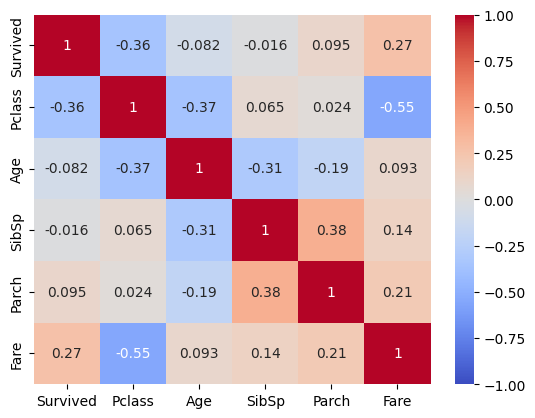

In [97]:
# Matrice de corrélation entre les variables numériques du dataframe
plt.show(sns.heatmap(datanic.corr(), vmin=-1, vmax=+1, annot=True, cmap="coolwarm"))


#### Est-ce que la classe et le genre influencent les chances de survie?

In [98]:
# Chances de survie par classe

datanic.pivot_table(index="Pclass", values=["Survived"], aggfunc=[np.mean, sum])


,mean,sum
,Survived,Survived
Pclass,,
1,0.652174,120
2,0.479769,83
3,0.239437,85


In [99]:
# Chances de survie par genre (non binaire exclu) et total

datanic.pivot_table(index=["Sex"], values=["Survived"], aggfunc=[np.mean, sum])


,mean,sum
,Survived,Survived
Sex,,
female,0.752896,195
male,0.205298,93


In [100]:
# Chances de survie par classe et par genre et total

datanic.pivot_table(
    index=["Pclass", "Sex"], values=["Survived"], aggfunc=[np.mean, sum]
)


mean      sum
               Survived Survived
Pclass Sex                      
1      female  0.963855       80
       male    0.396040       40
2      female  0.918919       68
       male    0.151515       15
3      female  0.460784       47
       male    0.150198       38

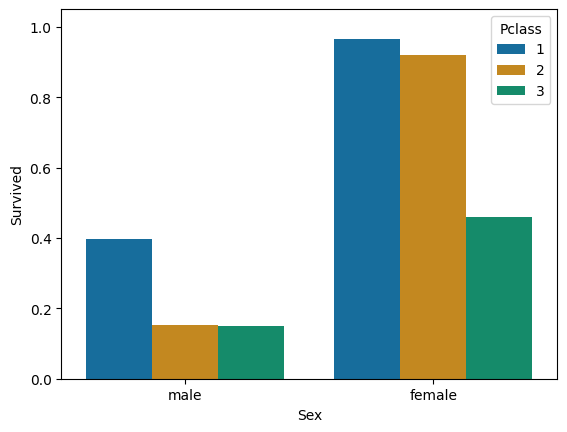

In [101]:
sns.barplot(
    data=datanic_small,
    x="Sex",
    y="Survived",
    hue="Pclass",
    palette="colorblind",
    estimator="mean",
    errwidth=0,
)
plt.show()


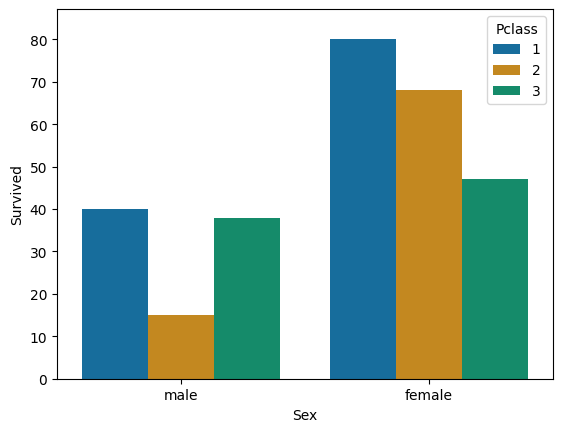

In [102]:
sns.barplot(
    data=datanic_small,
    x="Sex",
    y="Survived",
    hue="Pclass",
    palette="colorblind",
    estimator="sum",
    errwidth=0,
)
plt.show()


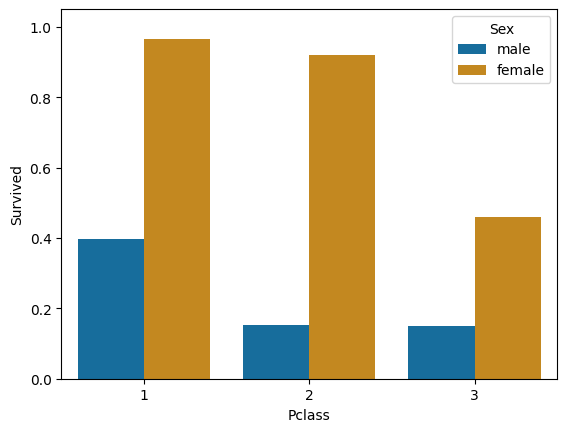

In [103]:
sns.barplot(
    data=datanic_small,
    x="Pclass",
    y="Survived",
    hue="Sex",
    palette="colorblind",
    estimator="mean",
    errwidth=0,
)
plt.show()


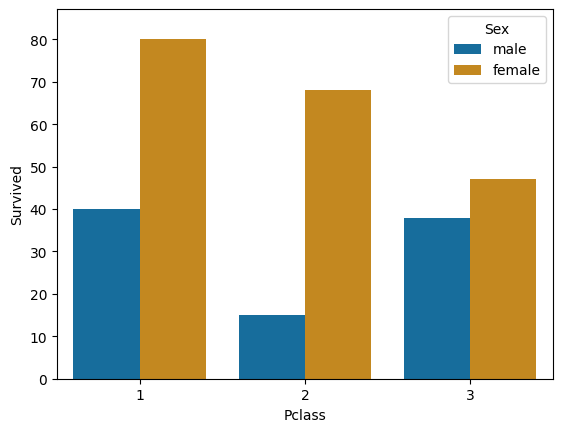

In [104]:
sns.barplot(
    data=datanic_small,
    x="Pclass",
    y="Survived",
    hue="Sex",
    palette="colorblind",
    estimator="sum",
    errwidth=0,
)
plt.show()


Les deux critères de classe et de genre semblent très discriminants dans la mesure du taux de survie des passagers.
Si on faisait un classement des personnes ayant davantage survécu, le résultat parle de lui-même :
1. Femme en 1ère classe
2. Femme en 2ème classe
3. Femme en 3ème classe
4. Homme en 1ère classe
5. Homme en 2ème classe
6. Homme en 3ème classe

On va explorer le reste des données pour essayer de voir s'il y a d'autres critères discriminants dans le taux de survie.

#### Est-ce que le lieu d'embarquement influence les chances de survie?

In [105]:
# Survie par lieu d'embarquement

datanic.pivot_table(index=["Embarked"], values=["Survived"], aggfunc=[np.mean, sum])


,mean,sum
,Survived,Survived
Embarked,,
C,0.607692,79
Q,0.285714,8
S,0.362816,201


In [106]:
datanic.loc[:, "Embarked"].value_counts()


S    554
C    130
Q     28
Name: Embarked, dtype: int64

In [107]:
datanic.groupby("Embarked").Survived.value_counts()


Embarked  Survived
C         1            79
          0            51
Q         0            20
          1             8
S         0           353
          1           201
Name: Survived, dtype: int64

In [108]:
datanic.groupby("Embarked").Pclass.value_counts()


Embarked  Pclass
C         1          74
          3          41
          2          15
Q         3          24
          1           2
          2           2
S         3         290
          2         156
          1         108
Name: Pclass, dtype: int64

Plusieurs données intéressantes sont à prendre en compte:
- Le lieu d'embarquement "Q" pour Queenstown en Irlande a été principalement utilisé par des personnes voyageant en 3ème classe. Seulement 2 personnes étaient en 1ère, 2 personnes en 2ème contre 24 personnes en 3ème.
- L'embarquement "C" pour Cherbourg en France a été principalement utilisé par des personnes voyegant en 1ère classe : 74 personnes contre seulement 15 pour la 2ème classe et 41 pour la 3ème classe. La catégorie "C" est donc davantage représentée par des personnes de 1ère classe alors que pour "Q" et "S" la 1ère classe est souvent la catégorie ayant le moins de voyageurs.

In [109]:
# Survie par lieu d'embarquement et par classe
datanic.pivot_table(
    index=["Embarked", "Pclass"], values=["Survived"], aggfunc=[np.mean, sum]
)


mean      sum
                 Survived Survived
Embarked Pclass                   
C        1       0.716216       53
         2       0.533333        8
         3       0.439024       18
Q        1       0.500000        1
         2       0.500000        1
         3       0.250000        6
S        1       0.611111       66
         2       0.474359       74
         3       0.210345       61

In [110]:
# Survie par lieu d'embarquement et par genre
datanic.pivot_table(
    index=["Embarked", "Sex"], values=["Survived"], aggfunc=[np.mean, sum]
)


mean      sum
                 Survived Survived
Embarked Sex                      
C        female  0.901639       55
         male    0.347826       24
Q        female  0.583333        7
         male    0.062500        1
S        female  0.715054      133
         male    0.184783       68

Pour "Q" : 
- 1ère et 2ème classe, seulement 2 personnes par classe et un taux de survie de 50% par classe. La moyenne n'est pas pertinente sur si peu de données.

Pour "C" :
- Le % de survie en 3ème classe est de 43%, supérieur à ceux de "Q" et "S", respectivement "25% et 21%". A voir si cela se justifie par une plus grande part de femmes dans le groupe "C"?

In [111]:
datanic.groupby("Embarked").Sex.value_counts()


Embarked  Sex   
C         male       69
          female     61
Q         male       16
          female     12
S         male      368
          female    186
Name: Sex, dtype: int64

La répartition par genre hors classe est plutôt homogène pour "Q" et "C", mais hétérogène pour "S". Il y a beaucoup plus d'hommes que de femmes ce qui peut aider à expliquer le taux de survie inférieur pour les personnes ayant embarqué à Southampton par rapport à Cherbourg ou Queenstown.

In [112]:
# Survie par lieu d'embarquement, par classe et par genre

datanic.pivot_table(
    index=["Embarked", "Pclass", "Sex"], values=["Survived"], aggfunc=[np.mean, sum]
)


mean      sum
                        Survived Survived
Embarked Pclass Sex                      
C        1      female  0.973684       37
                male    0.444444       16
         2      female  1.000000        7
                male    0.125000        1
         3      female  0.687500       11
                male    0.280000        7
Q        1      female  1.000000        1
                male    0.000000        0
         2      female  1.000000        1
                male    0.000000        0
         3      female  0.500000        5
                male    0.071429        1
S        1      female  0.954545       42
                male    0.375000       24
         2      female  0.909091       60
                male    0.155556       14
         3      female  0.407895       31
                male    0.140187       30

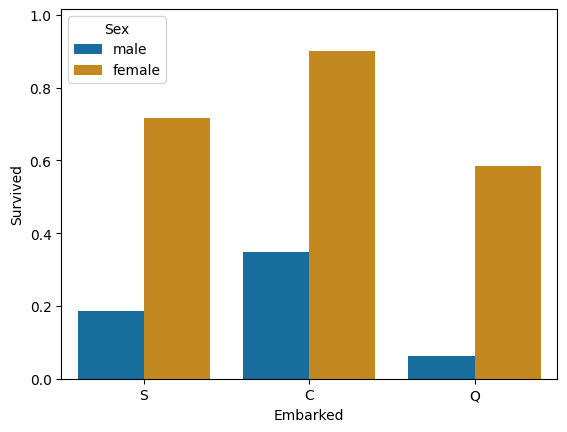

In [113]:
sns.barplot(
    data=datanic_medium,
    x="Embarked",
    y="Survived",
    hue="Sex",
    palette="colorblind",
    estimator="mean",
    errwidth=0,
)
plt.show()


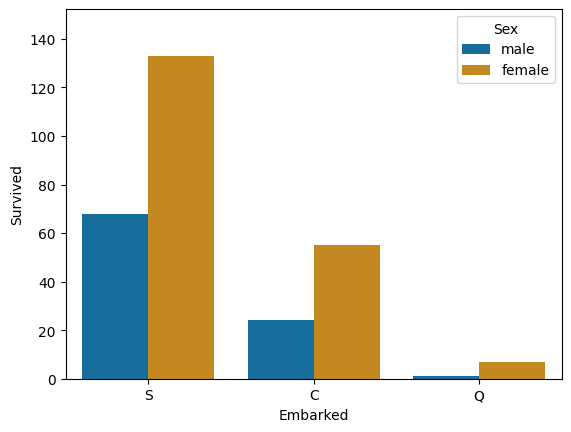

In [114]:
sns.barplot(
    data=datanic_medium,
    x="Embarked",
    y="Survived",
    hue="Sex",
    palette="colorblind",
    estimator="sum",
    errwidth=0,
)
plt.show()


On retrouve la même constante : les femmes ont davantage survécu que les hommes, qu'importe le lieu d'embarquement.
La différence entre les 3 catégories se situe plus dans la répartition des classes :
- Il y a plus de personnes en 1ère classe pour Cherbourg
- Il y a presque uniquement des personnes en 3ème classe pour Queenstown.

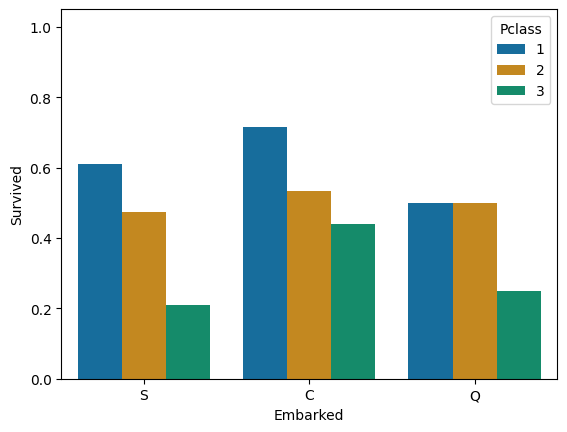

In [115]:
sns.barplot(
    data=datanic_medium,
    x="Embarked",
    y="Survived",
    hue="Pclass",
    palette="colorblind",
    estimator="mean",
    errwidth=0,
)
plt.show()


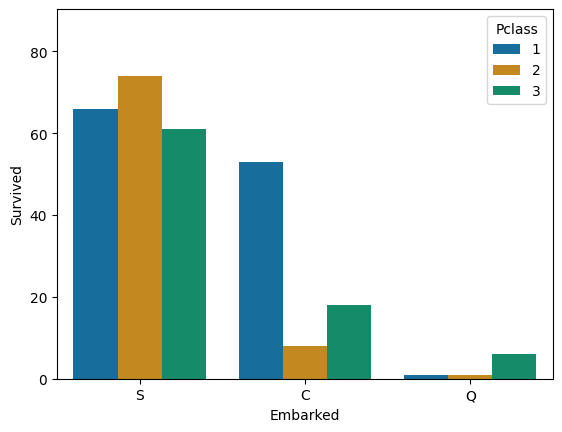

In [116]:
sns.barplot(
    data=datanic_medium,
    x="Embarked",
    y="Survived",
    hue="Pclass",
    palette="colorblind",
    estimator="sum",
    errwidth=0,
)
plt.show()


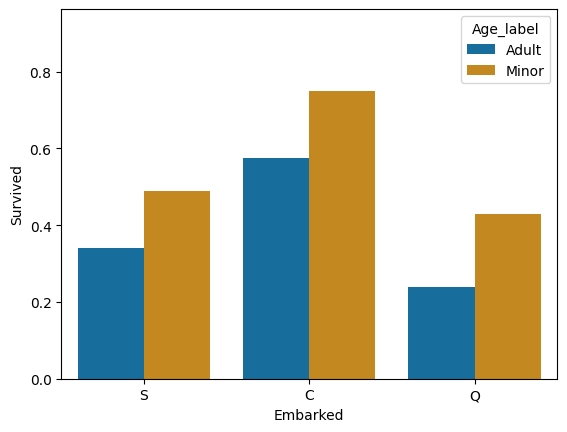

In [117]:
sns.barplot(
    data=datanic_medium,
    x="Embarked",
    y="Survived",
    hue="Age_label",
    palette="colorblind",
    estimator="mean",
    errwidth=0,
)
plt.show()


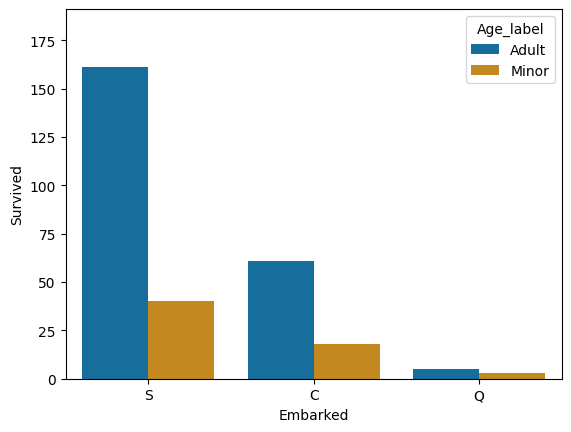

In [118]:
sns.barplot(
    data=datanic_medium,
    x="Embarked",
    y="Survived",
    hue="Age_label",
    palette="colorblind",
    estimator="sum",
    errwidth=0,
)
plt.show()


Le taux de survie semble donc toujours plus lié à deux critières:
- la classe du voyageur
- le genre

Y a t'il d'autres critères discriminants?

#### Est-ce que l'âge et la distinction adulte/mineur influencent les chances de survie?

In [119]:
datanic.pivot_table(index=["Age_label"], values=["Survived"], aggfunc=[np.mean, sum])


,mean,sum
,Survived,Survived
Age_label,,
Adult,0.378965,227
Minor,0.539823,61


In [120]:
datanic.pivot_table(
    index=["Age_label", "Sex"], values=["Survived"], aggfunc=[np.mean, sum]
)


mean      sum
                  Survived Survived
Age_label Sex                      
Adult     female  0.769608      157
          male    0.177215       70
Minor     female  0.690909       38
          male    0.396552       23

In [121]:
datanic.pivot_table(
    index=["Age_label", "Sex", "Pclass"], values=["Survived"], aggfunc=[np.mean, sum]
)


mean      sum
                         Survived Survived
Age_label Sex    Pclass                   
Adult     female 1       0.973333       73
                 2       0.903226       56
                 3       0.417910       28
          male   1       0.371134       36
                 2       0.068182        6
                 3       0.133333       28
Minor     female 1       0.875000        7
                 2       1.000000       12
                 3       0.542857       19
          male   1       1.000000        4
                 2       0.818182        9
                 3       0.232558       10

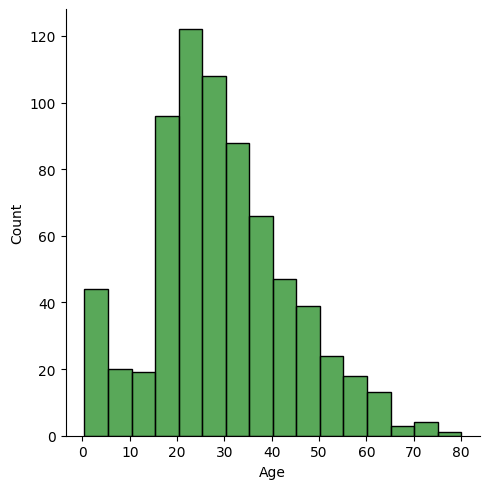

In [122]:
# Répartition par âge des passagers
vis1 = sns.displot(datanic["Age"], bins=16, color="forestgreen")


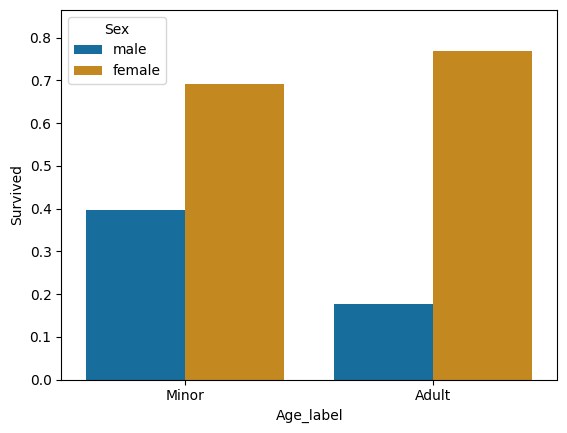

In [123]:
sns.barplot(
    data=datanic_medium,
    x="Age_label",
    y="Survived",
    hue="Sex",
    palette="colorblind",
    estimator="mean",
    order=["Minor", "Adult"],
    errwidth=0,
)
plt.show()


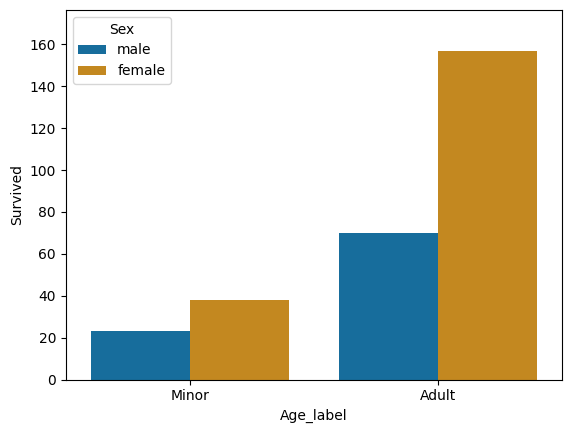

In [124]:
sns.barplot(
    data=datanic_medium,
    x="Age_label",
    y="Survived",
    hue="Sex",
    palette="colorblind",
    estimator="sum",
    order=["Minor", "Adult"],
    errwidth=0,
)
plt.show()


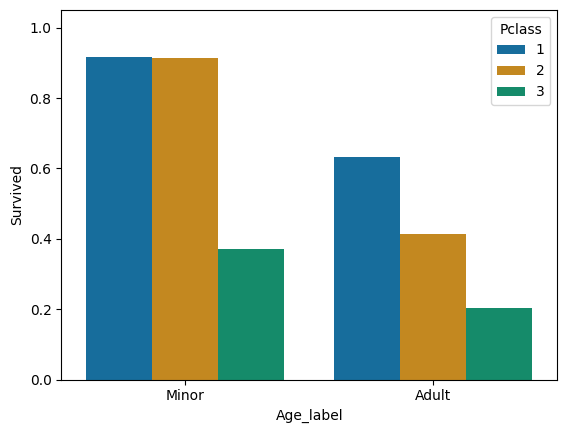

In [125]:
sns.barplot(
    data=datanic_medium,
    x="Age_label",
    y="Survived",
    hue="Pclass",
    palette="colorblind",
    estimator="mean",
    order=["Minor", "Adult"],
    errwidth=0,
)
plt.show()


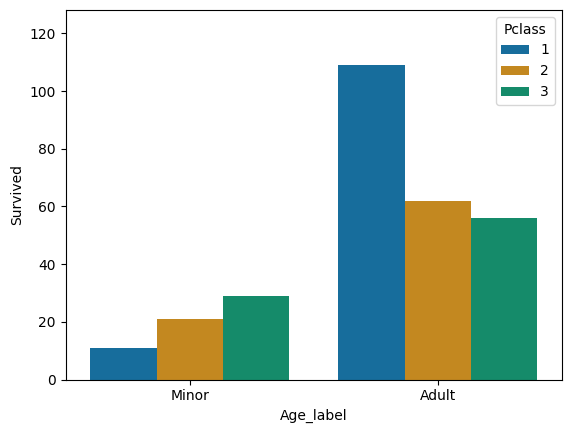

In [126]:
sns.barplot(
    data=datanic_medium,
    x="Age_label",
    y="Survived",
    hue="Pclass",
    palette="colorblind",
    estimator="sum",
    order=["Minor", "Adult"],
    errwidth=0,
)
plt.show()


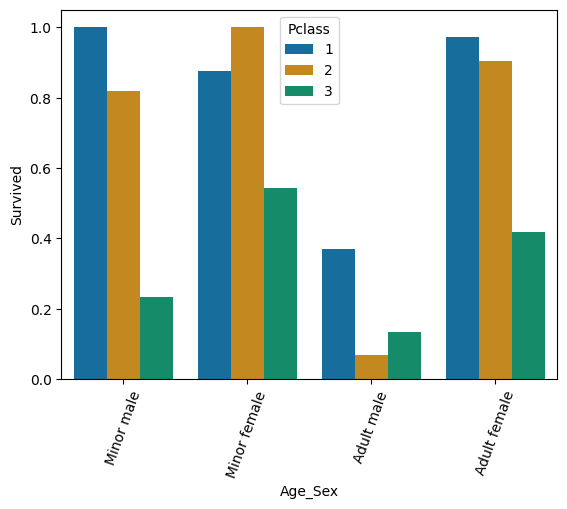

In [127]:
sns.barplot(
    data=datanic_medium,
    x="Age_Sex",
    y="Survived",
    hue="Pclass",
    palette="colorblind",
    order=["Minor male", "Minor female", "Adult male", "Adult female"],
    errwidth=0,
)
plt.xticks(rotation=70)
plt.show()


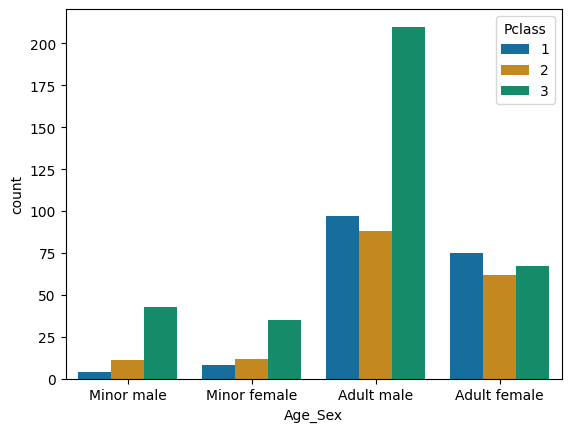

In [128]:
sns.countplot(
    data=datanic_small,
    x="Age_Sex",
    hue="Pclass",
    palette="colorblind",
    order=["Minor male", "Minor female", "Adult male", "Adult female"],
)
plt.show()


Le critère mineur/majeur réduit l'écart dans le taux de survie entre garçons et filles mais le taux de survie est toujours supérieur pour les filles (+/- 70%) que pour les garçons (+/- 39%). Les mineurs ont en tout cas un taux de survie supérieur aux adultes. A noter toutefois que l'échantillon pour les mineurs est moindre que pour les adultes.

Ce critère reste donc discriminatoire et peut être ajouté à ceux de classe et de genre pour étudier le taux de survie d'un passager.

### Est-ce que les chances de survie sont plus élevées quand on a payé son billet plus cher?

In [129]:
datanic.pivot_table(index=["Pclass"], values=["Fare", "Survived"], aggfunc=[np.mean])


mean          
             Fare  Survived
Pclass                     
1       88.048121  0.652174
2       21.471556  0.479769
3       13.229435  0.239437

In [130]:
datanic.pivot_table(
    index=["Pclass", "Sex"], values=["Fare", "Survived"], aggfunc=[np.mean]
)


mean          
                     Fare  Survived
Pclass Sex                         
1      female  108.619680  0.963855
       male     71.142781  0.396040
2      female   21.951070  0.918919
       male     21.113131  0.151515
3      female   15.875369  0.460784
       male     12.162695  0.150198

In [131]:
datanic.pivot_table(
    index=["Pclass", "Age_Sex"], values=["Fare", "Survived"], aggfunc=[np.mean]
)


mean          
                           Fare  Survived
Pclass Age_Sex                           
1      Adult female  109.103556  0.973333
       Adult male     69.289993  0.371134
       Minor female  104.083337  0.875000
       Minor male    116.072900  1.000000
2      Adult female   21.120632  0.903226
       Adult male     20.544839  0.068182
       Minor female   26.241667  1.000000
       Minor male     25.659473  0.818182
3      Adult female   14.385200  0.417910
       Adult male      9.994302  0.133333
       Minor female   18.727977  0.542857
       Minor male     22.752523  0.232558

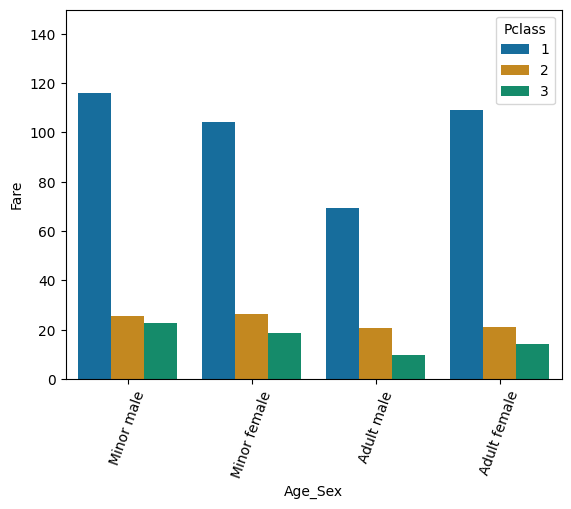

In [132]:
sns.barplot(
    data=datanic,
    x="Age_Sex",
    y="Fare",
    hue="Pclass",
    palette="colorblind",
    order=["Minor male", "Minor female", "Adult male", "Adult female"],
    errwidth=0,
)
plt.xticks(rotation=70)
plt.show()


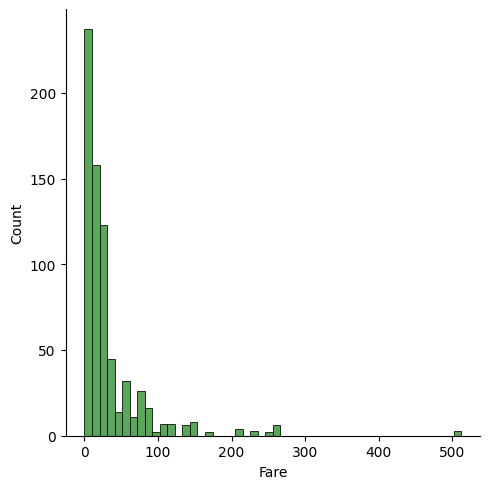

In [133]:
sns.displot(datanic["Fare"], bins=50, color="forestgreen")
plt.show()


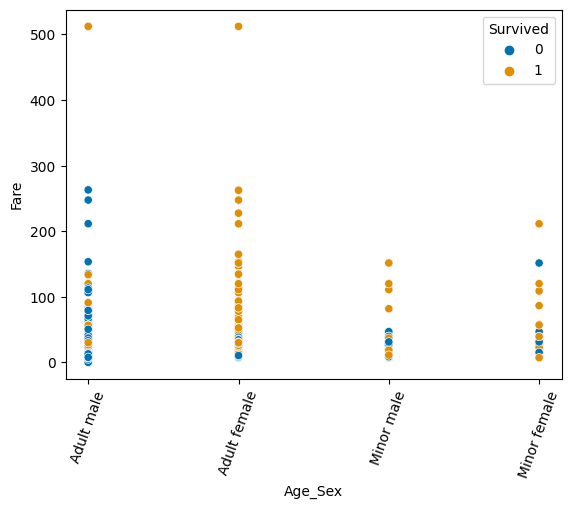

In [134]:
sns.scatterplot(
    data=datanic, x="Age_Sex", y="Fare", hue="Survived", palette="colorblind"
)
plt.xticks(rotation=70)
plt.show()


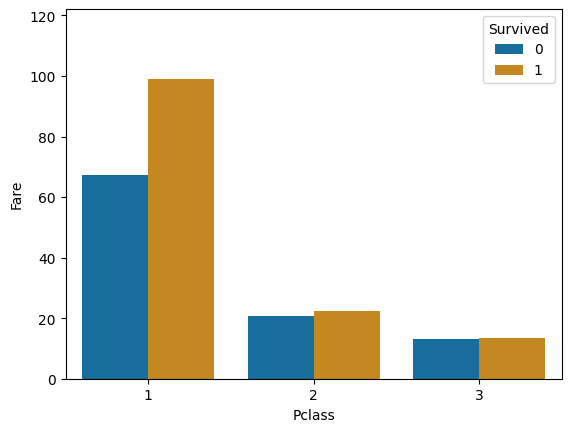

In [135]:
sns.barplot(
    data=datanic, x="Pclass", y="Fare", hue="Survived", palette="colorblind", errwidth=0
)
plt.show()


Un prix du ticket élevé semble augmenter les chances de survie mais il est peut être lié au port de départ ainsi qu'à la classe du voyageur.

### 1.c. Algorithme de machine learning : classification via SVC

#### Préparation de la base de données

In [136]:
datanic_encoded = datanic.copy()
datanic_encoded.drop(["Age_Sex"], axis=1)

encoder = LabelBinarizer()
datanic_encoded["Sex"] = encoder.fit_transform(datanic_encoded["Sex"])
datanic_encoded["Embarked"] = encoder.fit_transform(datanic_encoded["Embarked"])
datanic_encoded["Age_label"] = encoder.fit_transform(datanic_encoded["Age_label"])

datanic_encoded.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_label,Age_Sex
0,0,3,1,22.0,1,0,7.2500,0,0,Adult male
1,1,1,0,38.0,1,0,71.2833,1,0,Adult female
2,1,3,0,26.0,0,0,7.9250,0,0,Adult female
3,1,1,0,35.0,1,0,53.1000,0,0,Adult female
4,0,3,1,35.0,0,0,8.0500,0,0,Adult male


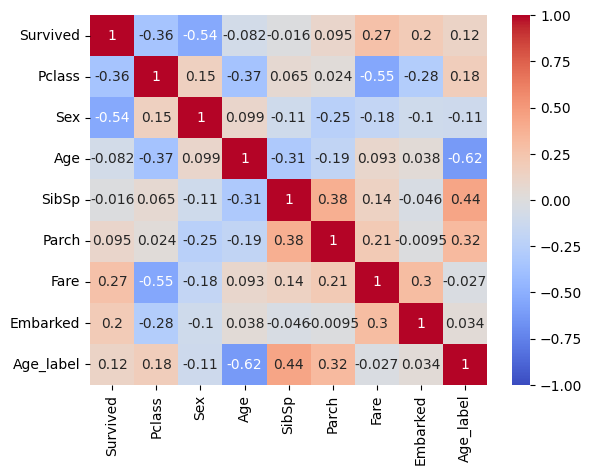

In [137]:
# Matrice de corrélation entre les variables numériques du dataframe nettoyé avant normalisation et algo
# Les valeurs de corrélation sont comprises entre -1 et +1.

plt.show(
    sns.heatmap(datanic_encoded.corr(), vmin=-1, vmax=+1, annot=True, cmap="coolwarm")
)


In [138]:
# On sépare les features du target
features, target = (
    datanic_encoded.loc[:, "Pclass":"Age_label"],
    datanic_encoded["Survived"],
)

# On split notre dataframe en 2
feat_train, feat_test, target_train, target_test = train_test_split(features, target)

# On normalise
scaler = MinMaxScaler()
feat_train = scaler.fit_transform(feat_train)
feat_test = scaler.transform(feat_test)


#### SVC avec un kernel linear

Métrique la plus pertinente : F1 score = 0.6885245901639345

Métrique additionnelle : Recall score = 0.65625

Métrique additionnelle : Precision score = 0.7241379310344828

Métrique additionnelle : Accuracy score = 0.7865168539325843



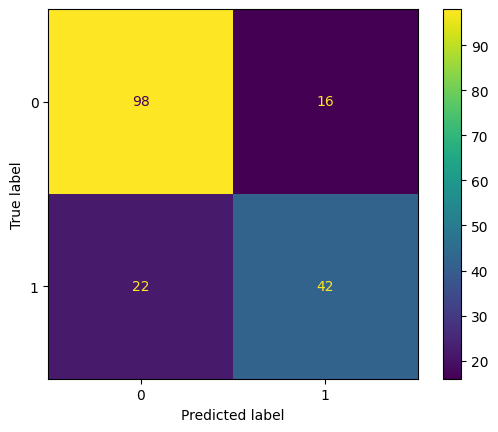

In [150]:
# On initalise le modèle
svc_classifier_linear = svm.SVC(kernel="linear", C=1.0)

# On l'entraîne sur nos données d'entraînement
svc_classifier_linear.fit(feat_train, target_train)

# On l'utilise pour prédire sur les données de test
predict = svc_classifier_linear.predict(feat_test)

# Métriques du modèle : f1 score, accuracy, recall, precision, accuracy
print(f"Métrique la plus pertinente : F1 score = {f1_score(target_test, predict)}\n")
print(f"Métrique additionnelle : Recall score = {recall_score(target_test, predict)}\n")
print(
    f"Métrique additionnelle : Precision score = {precision_score(target_test, predict)}\n"
)
print(
    f"Métrique additionnelle : Accuracy score = {accuracy_score(target_test, predict)}\n"
)

# Matrice de confusion
plt.show(
    ConfusionMatrixDisplay.from_estimator(svc_classifier_linear, feat_test, target_test)
)


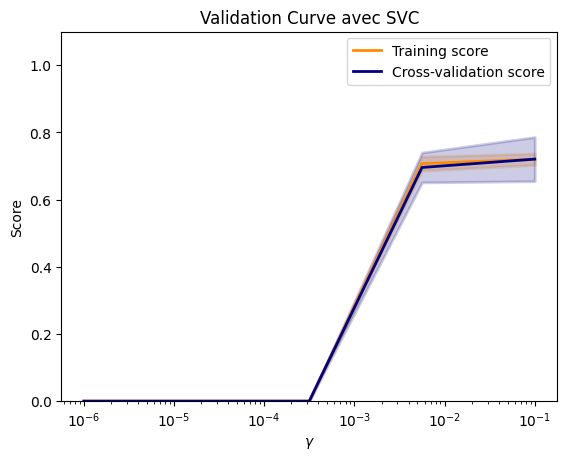

In [151]:
param_range = np.logspace(-6, -1, 5)

train_scores, valid_scores = validation_curve(
    SVC(),
    feat_train,
    target_train,
    param_name="gamma",
    param_range=param_range,
    scoring="f1",
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve avec SVC")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()


#### SVC avec un kernel rbf

Métrique la plus pertinente : F1 score = 0.7102803738317758

Métrique additionnelle : Recall score = 0.59375

Métrique additionnelle : Precision score = 0.8837209302325582

Métrique additionnelle : Accuracy score = 0.8258426966292135



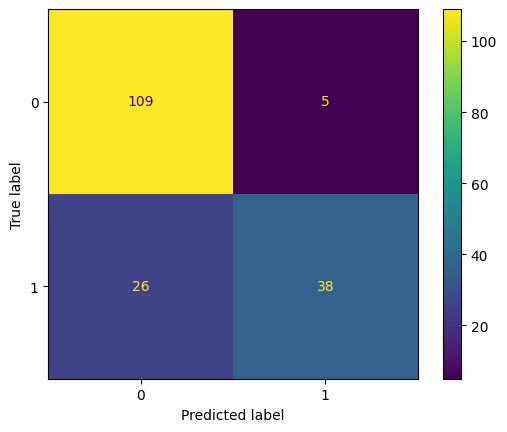

In [143]:
# On initalise le modèle
svc_classifier_rbf = svm.SVC(kernel="rbf", C=1.0)

# On l'entraîne sur nos données d'entraînement
svc_classifier_rbf.fit(feat_train, target_train)


# On l'utilise pour prédire sur les données de test
predict = svc_classifier_rbf.predict(feat_test)

# Métriques du modèle : f1 score, accuracy, recall, precision, accuracy
print(f"Métrique la plus pertinente : F1 score = {f1_score(target_test, predict)}\n")
print(f"Métrique additionnelle : Recall score = {recall_score(target_test, predict)}\n")
print(
    f"Métrique additionnelle : Precision score = {precision_score(target_test, predict)}\n"
)
print(
    f"Métrique additionnelle : Accuracy score = {accuracy_score(target_test, predict)}\n"
)

# Matrice de confusion
plt.show(
    ConfusionMatrixDisplay.from_estimator(svc_classifier_rbf, feat_test, target_test)
)


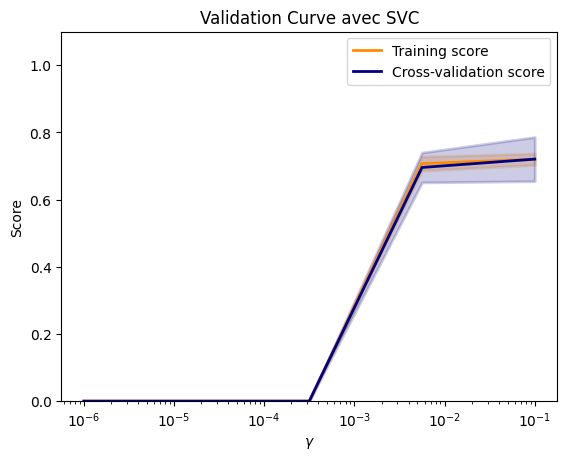

In [153]:
param_range = np.logspace(-6, -1, 5)

train_scores, valid_scores = validation_curve(
    svc_classifier_rbf,
    feat_train,
    target_train,
    param_name="gamma",
    param_range=param_range,
    scoring="f1",
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve avec SVC")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()


Les deux courbes, celle du training score et celle de la cross-validation, se rejoignent presque même si la courbe de training score semble encore très légèrement au dessus (ce qui est logique puisqu'il s'agit de la courbe d'entraînement).

## 2. Optimisation avec GridSearchCV et pipelines

### 2.a. SVC avec GridSearchCV

In [154]:
# Imports spécifiques au notebook 2

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Imports de scikit-learn
from sklearn import metrics, model_selection, preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    LabelBinarizer,
    OneHotEncoder,
)
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
    roc_curve,
)
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

# Imports pour GridSearchCV (SVC/KNN)
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

# Imports spécifiques pour les pipelines
from sklearn import pipeline
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Résultats de la validation croisée :

f1 = 0.720 (+/-0.131) for {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
f1 = 0.731 (+/-0.148) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
f1 = 0.720 (+/-0.131) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
f1 = 0.720 (+/-0.131) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
f1 = 0.720 (+/-0.131) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
f1 = 0.000 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
f1 = 0.720 (+/-0.131) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
f1 = 0.000 (+/-0.000) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
f1 = 0.720 (+/-0.131) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
f1 = 0.000 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
f1 = 0.720 (+/-0.131) for {'C': 1, 'gamma': 1, 'kernel': 'linear'}
f1 = 0.730 (+/-0.048) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
f1 = 0.720 (+/-0.131) for {'C': 1, 'gamma': 0.1, 'kernel': 'linear

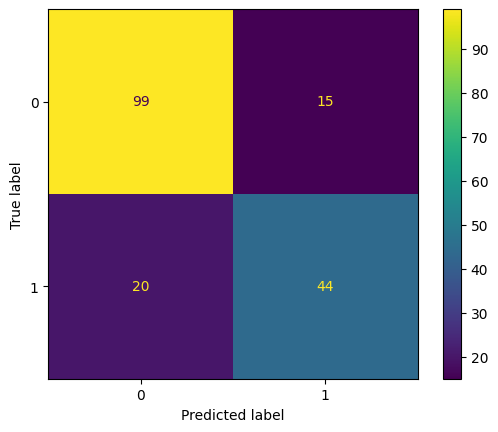

In [165]:
# On fixe les valeurs des hyperparamètres à tester
parameters = {
    "C": [0.1, 1, 10],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ("linear", "rbf"),
}

# Choisir un score à optimiser, ici le F1 score
score = "f1"

# Créer un classifieur SVC avec ses hyperparamètres
svc = svm.SVC(gamma="scale")
svc_classifier = model_selection.GridSearchCV(svc, parameters, scoring=score, verbose=1)

# On l'entraîne sur nos données d'entraînement
svc_classifier.fit(feat_train, target_train)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :\n")
for mean, std, params in zip(
    svc_classifier.cv_results_["mean_test_score"],
    svc_classifier.cv_results_["std_test_score"],
    svc_classifier.cv_results_["params"],
):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(score, mean, std * 2, params))

y_pred = svc_classifier.predict(feat_test)
y_true = target_test

print("\n", classification_report(y_true, y_pred))

# Matrice de confusion
plt.show(ConfusionMatrixDisplay.from_estimator(svc_classifier, feat_test, target_test))


In [166]:
print(f"Best parameters : {svc_classifier.best_params_}\n")
print(f"Best f1 score : {svc_classifier.best_score_}\n")
print(f"Best estimator : {svc_classifier.best_estimator_}")


Best parameters : {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Best score : 0.7525325249463181

Best estimator : SVC(C=10, gamma=0.1)


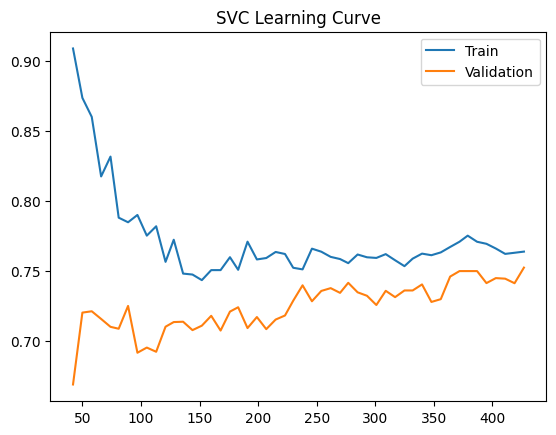

In [167]:
# SVC Learning Curve

train_sizes, train_scores, valid_scores = learning_curve(
    svc_classifier.best_estimator_,
    feat_train,
    target_train,
    train_sizes=np.linspace(0.1, 1, 50),
    cv=5,
    scoring="f1",
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label="Validation")
plt.title("SVC Learning Curve")
plt.legend()
plt.show()


La courbe de validation de SVC montre toutefois qu'elle continue de progresser et de se rapprocher au plus près de la courbe d'entraînement.

On va ensuite comparer les mêmes données d'entraînement avec l'algorithme KNN (choix suivant dans le guide de scikit-learn pour choisir son algorithme).

### 2.b. Comparaison avec KNN GridSearchCV

Résultats de la validation croisée :

f1 = 0.669 (+/-0.072) for {'n_neighbors': 2}
f1 = 0.754 (+/-0.033) for {'n_neighbors': 3}
f1 = 0.704 (+/-0.059) for {'n_neighbors': 4}
f1 = 0.755 (+/-0.055) for {'n_neighbors': 5}
f1 = 0.710 (+/-0.072) for {'n_neighbors': 6}
f1 = 0.747 (+/-0.102) for {'n_neighbors': 7}
f1 = 0.731 (+/-0.081) for {'n_neighbors': 8}
f1 = 0.738 (+/-0.062) for {'n_neighbors': 9}
f1 = 0.732 (+/-0.086) for {'n_neighbors': 10}
f1 = 0.746 (+/-0.103) for {'n_neighbors': 11}
f1 = 0.730 (+/-0.098) for {'n_neighbors': 12}
f1 = 0.733 (+/-0.095) for {'n_neighbors': 13}
f1 = 0.711 (+/-0.097) for {'n_neighbors': 14}
f1 = 0.726 (+/-0.079) for {'n_neighbors': 15}
f1 = 0.718 (+/-0.068) for {'n_neighbors': 16}
f1 = 0.716 (+/-0.057) for {'n_neighbors': 17}
f1 = 0.720 (+/-0.082) for {'n_neighbors': 18}
f1 = 0.718 (+/-0.064) for {'n_neighbors': 19}
f1 = 0.716 (+/-0.093) for {'n_neighbors': 20}
f1 = 0.722 (+/-0.093) for {'n_neighbors': 21}
f1 = 0.696 (+/-0.107) for {'n_neighbors': 22}
f1 =

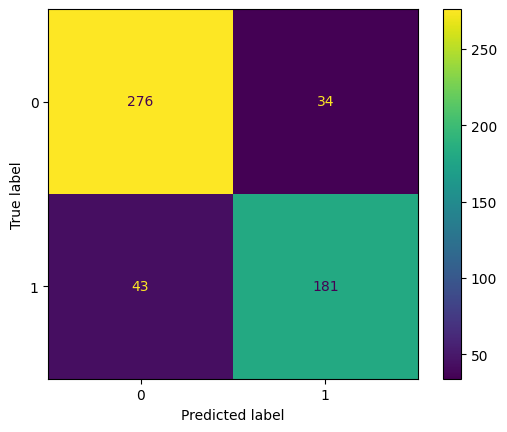


               precision    recall  f1-score   support

           0       0.87      0.89      0.88       310
           1       0.84      0.81      0.82       224

    accuracy                           0.86       534
   macro avg       0.85      0.85      0.85       534
weighted avg       0.86      0.86      0.86       534



In [168]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"n_neighbors": range(2, 51)}

# Choisir un score à optimiser, ici le F1 score
score = "f1"

# Créer un classifieur kNN avec ses hyperparamètre
knn_classifier = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(),  # un classifieur kNN
    param_grid,  # hyperparamètres à tester
    scoring=score,
)  # score à optimiser

knn_classifier.fit(feat_train, target_train)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :\n")
for mean, std, params in zip(
    knn_classifier.cv_results_["mean_test_score"],
    knn_classifier.cv_results_["std_test_score"],
    knn_classifier.cv_results_["params"],
):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(score, mean, std * 2, params))

y_pred = knn_classifier.predict(feat_train)
y_true = target_train

plt.show(
    ConfusionMatrixDisplay.from_estimator(knn_classifier, feat_train, target_train)
)

print("\n", classification_report(y_true, y_pred))


In [169]:
print(f"Best parameters : {knn_classifier.best_params_}\n")
print(f"Best f1 score : {knn_classifier.best_score_}\n")
print(f"Best estimator : {knn_classifier.best_estimator_}")


Best parameters : {'n_neighbors': 5}

Best score : 0.7545994388280606

Best estimator : KNeighborsClassifier()


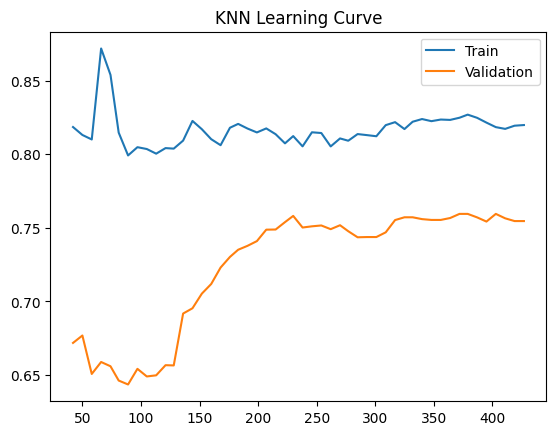

In [172]:
train_sizes, train_scores, valid_scores = learning_curve(
    knn_classifier.best_estimator_,
    feat_train,
    target_train,
    train_sizes=np.linspace(0.1, 1, 50),
    cv=5,
    scoring="f1",
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label="Validation")
plt.title("KNN Learning Curve")
plt.legend()
plt.show()


Les résultats sont assez proches entre l'algo KNN en GridSearchCV et SVC en GridSearchCV avec une différence de +/- 1% entre les deux au niveau de l'accuracy.

La courbe de validation dans la learning curve de KNN termine en ligne droite ce qui laisse à penser que le modèle a atteint une limite d'apprentissage. Et son score f1 autour de 75-76% laisse à penser que KNN est au même niveau que SVC.  Par contre, pour KNN, la courbe de validation se terminait en hausse à l'inverse de KNN.

### 2.c. Algorithmes avec preprocessing et pipelines

#### Preprocessing et création de la pipeline pour l'encodage

In [173]:
# On copie le dataframe et on retire la colonne non Age_Sex créé pour l'analyse exploratoire des données
datanic_for_pipeline = datanic.copy()
datanic_for_pipeline.drop(["Age_Sex"], axis=1)
datanic_for_pipeline.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_label,Age_Sex
0,0,3,male,22.0,1,0,7.2500,S,Adult,Adult male
1,1,1,female,38.0,1,0,71.2833,C,Adult,Adult female
2,1,3,female,26.0,0,0,7.9250,S,Adult,Adult female
3,1,1,female,35.0,1,0,53.1000,S,Adult,Adult female
4,0,3,male,35.0,0,0,8.0500,S,Adult,Adult male


In [174]:
# Preprocessing et encodage des données en fonction de leur type numerical/categorical

numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

preprocessor = make_column_transformer(
    (MinMaxScaler(), numerical_features), (OneHotEncoder(), categorical_features)
)


In [175]:
# On sépare les features du target
features, target = (
    datanic_for_pipeline.loc[:, "Pclass":"Age_label"],
    datanic_for_pipeline["Survived"],
)

# On split notre dataframe en 2
feat_train, feat_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25
)


In [177]:
model = make_pipeline(preprocessor, SVC())
model.fit(feat_train, target_train)
model.predict(feat_test)


array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0])

#### Création de la pipeline pour les algos SVC et KNN + tests et learning curve

In [178]:
# Estimator pour la pipeline des algos
class Estimator(BaseEstimator):
    def fit(self):
        pass

    def score(self):
        pass


# Création de la pipeline
pipe = Pipeline([("preprocessing", preprocessor), ("classifier", Estimator())])


In [180]:
# Algorithme SVC avec hyperparamètres et affichage des résultats
search_space_svc = [
    {
        "classifier": [SVC()],
        "classifier__C": (0.1, 1, 10),
        "classifier__gamma": (0.1, 1, 10),
        "classifier__kernel": ("linear", "rbf"),
    }
]

# Le kernel poly tourne dans le vide sans aucune erreur donc je l'ai enlevé des paramètres, de même que C de 100 et gamma de 100

# Création de la grid search
grid_cv_svc = GridSearchCV(
    estimator=pipe,
    param_grid=search_space_svc,
    scoring="f1",
    cv=5,
    n_jobs=2,
    verbose=True,
)
grid_cv_svc.fit(feat_train, target_train)

# Tests et prints pour vérifier le meilleur score et meilleurs paramètres
print(f"Meilleur score f1: {grid_cv_svc.best_score_}")
final_classifier_1 = grid_cv_svc.best_estimator_
print(f"Validation score: {final_classifier_1.score(feat_test,target_test)}")
print(f"\n\Meilleur classifier: {final_classifier_1}")
print(f"\Meilleurs paramètres: {grid_cv_svc.best_params_}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Meilleur score f1: 0.7580926760712979
Validation score: 0.797752808988764

\Meilleur classifier: Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125a1e0e0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125a1e530>)])),
                ('classifier', SVC(C=10, gamma=1))])
\Meilleurs paramètres: {'classifier': SVC(C=10, gamma=1), 'classifier__C': 10, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}


In [181]:
pd.DataFrame(grid_cv_svc.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.072440,0.028930,0.038342,0.012687,"SVC(C=10, gamma=1)",0.1,0.1,linear,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.704545,0.746988,0.773333,0.740741,0.680851,0.729292,0.032689,6
1,0.083898,0.035179,0.033634,0.015338,"SVC(C=10, gamma=1)",0.1,0.1,rbf,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.704545,0.746988,0.773333,0.740741,0.680851,0.729292,0.032689,6
2,0.029216,0.004552,0.012779,0.001688,"SVC(C=10, gamma=1)",0.1,1,linear,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.704545,0.746988,0.773333,0.740741,0.680851,0.729292,0.032689,6
3,0.035045,0.002882,0.023021,0.006764,"SVC(C=10, gamma=1)",0.1,1,rbf,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.712644,0.746988,0.788732,0.740741,0.695652,0.736951,0.031915,5
4,0.034671,0.003201,0.022533,0.009090,"SVC(C=10, gamma=1)",0.1,10,linear,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.704545,0.746988,0.773333,0.740741,0.680851,0.729292,0.032689,6
5,0.035568,0.001888,0.018517,0.000693,"SVC(C=10, gamma=1)",0.1,10,rbf,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.694444,0.656716,0.721311,0.720930,0.597403,0.678161,0.046772,18
6,0.024098,0.002103,0.010770,0.000990,"SVC(C=10, gamma=1)",1,0.1,linear,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.704545,0.746988,0.773333,0.740741,0.680851,0.729292,0.032689,6
7,0.028944,0.004127,0.027300,0.023557,"SVC(C=10, gamma=1)",1,0.1,rbf,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.704545,0.746988,0.773333,0.740741,0.680851,0.729292,0.032689,6
8,0.024484,0.003392,0.012337,0.002017,"SVC(C=10, gamma=1)",1,1,linear,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.704545,0.746988,0.773333,0.740741,0.680851,0.729292,0.032689,6
9,0.028020,0.001735,0.013322,0.000554,"SVC(C=10, gamma=1)",1,1,rbf,"{'classifier': SVC(C=10, gamma=1), 'classifier...",0.756098,0.746667,0.761905,0.722892,0.720930,0.741698,0.016884,4


In [182]:
warnings.filterwarnings("ignore")

pd.DataFrame(grid_cv_svc.cv_results_).max(numeric_only=None)


mean_fit_time               0.083898
std_fit_time                0.035179
mean_score_time             0.038342
std_score_time              0.023557
param_classifier__C               10
param_classifier__gamma           10
param_classifier__kernel         rbf
split0_test_score           0.771084
split1_test_score           0.759494
split2_test_score           0.821918
split3_test_score           0.756098
split4_test_score            0.73913
mean_test_score             0.758093
std_test_score              0.046772
rank_test_score                   18
dtype: object

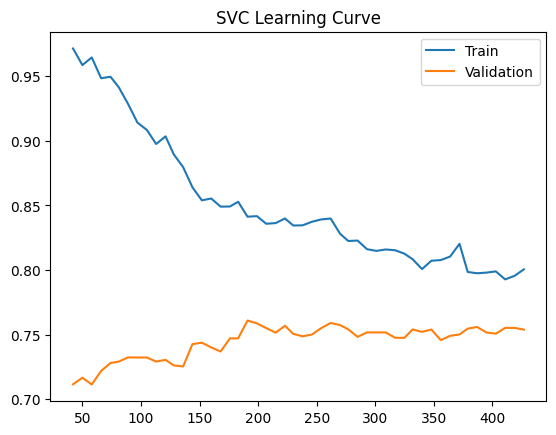

In [189]:
# SVC Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    grid_cv_svc.best_estimator_,
    feat_train,
    target_train,
    train_sizes=np.linspace(0.1, 1, 50),
    cv=5,
    scoring="f1",
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label="Validation")
plt.title("SVC Learning Curve")
plt.legend()
plt.show()


La learning curve de SVC termine cette fois par une ligne qui donne l'impression de stagner et d'être une ligne droite, comme si l'algorithme a atteint son maximum de progression.

In [185]:
# Algorithme KNN avec hyperparamètres et affichage des résultats
search_space_knn = [
    {
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": list(range(1, 51)),
        "classifier__p": [1, 2],
        "classifier__weights": ["uniform", "distance"],
        "classifier__algorithm": ["auto"],
    }
]

# Création de la grid search
grid_cv_knn = GridSearchCV(
    estimator=pipe,
    param_grid=search_space_knn,
    scoring="f1",
    cv=5,
    n_jobs=2,
    verbose=True,
)
grid_cv_knn.fit(feat_train, target_train)

# Tests et prints pour vérifier le meilleur score et meilleurs paramètres
print(f"Meilleur score: {grid_cv_knn.best_score_}")
final_classifier_knn = grid_cv_knn.best_estimator_
print(f"Validation score: {final_classifier_knn.score(feat_test,target_test)}")
print(f"\n\Meilleur classifier: {final_classifier_knn}")
print(f"\Meilleurs paramètres: {grid_cv_knn.best_params_}")


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Meilleur score: 0.7592818543680816
Validation score: 0.7865168539325843

\Meilleur classifier: Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125a1f100>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125a1d720>)])),
                ('classifier', KNeighborsClassifier(n_neighbors=9, p=1))])
\Meilleurs paramètres: {'classifier': KNeighborsClassifier(n_neighbors=9, p=1), 'classifier__algorithm': 'auto', 'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'uniform'}


In [186]:
# Résultats condensés dans un dataframe pour l'algorithme KNN
pd.DataFrame(grid_cv_knn.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__algorithm,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037466,0.012709,0.050699,0.019364,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,1,1,uniform,{'classifier': KNeighborsClassifier(n_neighbor...,0.705882,0.698795,0.753247,0.659091,0.693069,0.702017,0.030241,195
1,0.015881,0.004239,0.009532,0.000885,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,1,1,distance,{'classifier': KNeighborsClassifier(n_neighbor...,0.705882,0.698795,0.753247,0.659091,0.693069,0.702017,0.030241,195
2,0.015126,0.002924,0.020583,0.003059,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,1,2,uniform,{'classifier': KNeighborsClassifier(n_neighbor...,0.720930,0.682927,0.753247,0.636364,0.700000,0.698693,0.039002,199
3,0.013616,0.001732,0.011207,0.002725,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,1,2,distance,{'classifier': KNeighborsClassifier(n_neighbor...,0.720930,0.682927,0.753247,0.636364,0.700000,0.698693,0.039002,199
4,0.016361,0.002919,0.025026,0.014815,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,2,1,uniform,{'classifier': KNeighborsClassifier(n_neighbor...,0.675325,0.704225,0.741935,0.657895,0.750000,0.705876,0.036015,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.016732,0.002934,0.016661,0.001584,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,49,2,distance,{'classifier': KNeighborsClassifier(n_neighbor...,0.720930,0.716049,0.736842,0.705882,0.717391,0.719419,0.010045,154
196,0.020179,0.004662,0.026384,0.004693,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,50,1,uniform,{'classifier': KNeighborsClassifier(n_neighbor...,0.712644,0.756098,0.810811,0.716049,0.695652,0.738251,0.041344,38
197,0.022620,0.005478,0.021810,0.007677,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,50,1,distance,{'classifier': KNeighborsClassifier(n_neighbor...,0.731707,0.740741,0.736842,0.714286,0.760870,0.736889,0.015018,47
198,0.024220,0.010013,0.026461,0.006600,"KNeighborsClassifier(n_neighbors=9, p=1)",auto,50,2,uniform,{'classifier': KNeighborsClassifier(n_neighbor...,0.712644,0.756098,0.788732,0.716049,0.703297,0.735364,0.032236,60


In [187]:
warnings.filterwarnings("ignore")

pd.DataFrame(grid_cv_knn.cv_results_).max(numeric_only=None)


mean_fit_time                    0.105126
std_fit_time                     0.073675
mean_score_time                  0.136797
std_score_time                   0.113914
param_classifier__algorithm          auto
param_classifier__n_neighbors          50
param_classifier__p                     2
param_classifier__weights         uniform
split0_test_score                0.790123
split1_test_score                0.819277
split2_test_score                0.833333
split3_test_score                0.794521
split4_test_score                 0.76087
mean_test_score                  0.759282
std_test_score                   0.062418
rank_test_score                       199
dtype: object

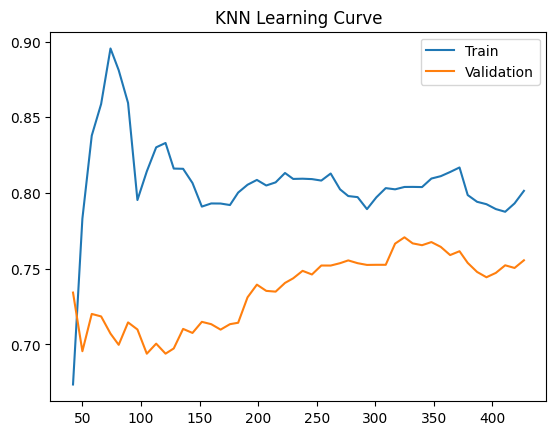

In [190]:
train_sizes, train_scores, valid_scores = learning_curve(
    grid_cv_knn.best_estimator_,
    feat_train,
    target_train,
    train_sizes=np.linspace(0.1, 1, 50),
    cv=5,
    scoring="f1",
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label="Validation")
plt.title("KNN Learning Curve")
plt.legend()
plt.show()


Le meilleur F1 score mesuré est de +/- équivalant entre l'algorithme KNN et l'algorithme SVC.
Le validation score est 1% plus élévé avec SVC qu'avec KNN.

En terme de learning curve, SVC termine cette fois en stagnant à l'inverse de KNN qui termine en hausse sur cet échantillon de la base de données.

En conclusion les mesures entre SVC et KNN ont des similitudes et sont assez proches, on pourrait donc aller plus loin notamment en faisant la comparaison avec d'autres algorithmes.

#### Pour aller plus loin

Pour poursuivre ce projet au delà du temps imparti, il pourrait donc être intéressant de :
- continuer la comparaison avec d'autres algorithmes de classification pour comparer les mesures du F1 score.
- faire des courbes AUC pour comparer avec un autre type de métrique
- diminuer la dimensionnalité en retirant du jeu de données les colonnes SibSp et Parch.
- ou adopter une approche différente avec les données : utiliser la colonnes "Name" pour essayer de faire le lien entre les familles et les chances de survies de celles-ci, ainsi que faire le lien avec le "titre/position dans la société" de ces personnes.
- poursuivre le tuning des hyperparamètres et comparer les résultats entre les différents algorithmes.